In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm
from src.qwen import load_qwen
import re
import yaml
import json
import gc
from torch.utils.data import TensorDataset, DataLoader
import transformers
from transformers import AutoModelForCausalLM

/home/am3353/am3353/m2-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Device-activated: ', device)

file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path  Out [9]:  Device-activated:  cpu
final_model_config_path = 'saves/hyper/hyperparameter_results.json'
final_model_path = 'saves/final_model.pt'

Device-activated:  cpu


In [3]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              76
On-line CPU(s) list: 0-75
Thread(s) per core:  1
Core(s) per socket:  38
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               106
Model name:          Intel(R) Xeon(R) Platinum 8368Q CPU @ 2.60GHz
Stepping:            6
CPU MHz:             2825.834
CPU max MHz:         3700.0000
CPU min MHz:         800.0000
BogoMIPS:            5200.00
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            58368K
NUMA node0 CPU(s):   0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74
NUMA node1 CPU(s):   1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush 

In [111]:
import src
import src.data_prepare_ntbk
import src.forecast 
import src.preprocess
import src.lora 
import src.data_create

importlib.reload(src)
importlib.reload(src.forecast)
importlib.reload(src.preprocess)
importlib.reload(src.lora)
importlib.reload(src.data_create)
importlib.reload(src.data_prepare_ntbk)

from src.forecast import *
from src.lora import LoRALinear
from src.preprocess import *
from src.data_create import *
from src.data_prepare_ntbk import *  

In [5]:
random_state = 28
np.random.seed(random_state)     

In [6]:
ft = time.time()
_, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

# pprint(model_lora.config)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.18432984352111817 mins


Can directly load modified model --> LoRATrainer.get_model()

In [7]:
def load_config(config_path):
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

In [9]:
manual_config = load_config("src/config.yaml")  

train_split = manual_config['train_split']
time_step_split = manual_config['time_step_split']
batch_size = manual_config['batch_size']
learning_rate = manual_config['learning_rate'] # 1e-5
lora_rank = manual_config['lora_rank']
max_ctx_length = manual_config['seq_length']
forecast_length = manual_config['forecast_length']
max_tokens = manual_config['max_tokens']  

##### Final Model Config

In [ ]:
with open(final_model_config_path, 'r') as file:
        best_config = json.load(file)
file.close()

best_config = best_config[1]
lora_rank = best_config['lora_rank']
max_ctx_length = best_config['context_length']
max_tokens = best_config['context_length']

print('lora-rank: ', lora_rank, ', context-length: ', max_ctx_length, ', max-tokens: ', max_tokens)

In [10]:
# model_lora.config.max_position_embeddings = max_ctx_length

In [102]:
data_prey, data_prey_true, data_pred, data_pred_true, time_data_past, time_data_true = load_data(file_path, time_step_split, is_plot = True)
print(data_prey.shape, data_prey_true.shape, data_pred.shape, data_pred_true.shape, time_data_past.shape, time_data_true.shape)

check_rn = random.randint(0, len(data_prey))
print('check_rn: ', check_rn)

Keys in HDF5 file: ['time', 'trajectories']
(1000, 80) (1000, 21) (1000, 80) (1000, 21) (80,) (21,)
check_rn:  360


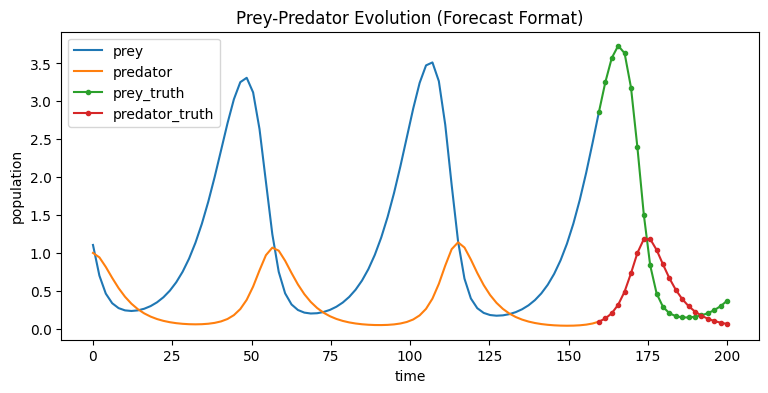

In [103]:
fig = plt.figure(figsize=(9, 4))

plt.plot(time_data_past, data_prey[check_rn], label = 'prey')
plt.plot(time_data_past, data_pred[check_rn], label = 'predator')

plt.plot(time_data_true, data_prey_true[check_rn], label = 'prey_truth', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn], label = 'predator_truth', marker = '.')

plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution (Forecast Format)')
plt.show()  

In [12]:
train_input_ids, val_input_ids, prey_os, pred_os, test_encoded = prepare_data(data_prey, data_pred, tokenizer, max_ctx_length, train_split, forecast_length=forecast_length, is_forecast=True)
print(train_input_ids.shape, val_input_ids.shape, test_encoded.shape)


sample-train-encoded:
0.247,1.05;0.234,0.806;0.232,0

torch.Size([3200, 512]) torch.Size([1600, 512]) (200,)


In [45]:
train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size)  

In [58]:
for (batch_t, ) in train_loader:
    print(batch_t.shape)
    break

torch.Size([4, 512])


#### Loading Saved Model (Direct Architechture + Weights Load)

In [39]:
# final_model_path = 'saves/best_final_model.pt' ### ran through final_model.py

# check_model_path = 'saves/final_model.pt' ### ran throung lora_train.py (changed to lora_model.pt)
# check_model_path = 'saves/lora_model.pt' ### ran throung lora_train.py (changed to lora_model.pt)
checkpoint_model_path = 'saves/checkpoint/lora_step_5000.pt'

In [40]:
# model_lora = AutoModelForCausalLM.from_pretrained(final_model_path, trust_remote_code=True)
# model_lora = AutoModelForCausalLM.from_pretrained(check_model_path, trust_remote_code=True)
model_lora = AutoModelForCausalLM.from_pretrained(checkpoint_model_path, trust_remote_code=True)
model_lora.eval()

Some weights of the model checkpoint at saves/checkpoint/lora_step_5000.pt were not used when initializing Qwen2ForCausalLM: {'model.layers.2.self_attn.q_proj.A', 'model.layers.4.self_attn.v_proj.A', 'model.layers.0.self_attn.v_proj.original_linear.bias', 'model.layers.4.self_attn.v_proj.original_linear.bias', 'model.layers.0.self_attn.q_proj.B', 'model.layers.14.self_attn.q_proj.B', 'model.layers.1.self_attn.q_proj.original_linear.weight', 'model.layers.17.self_attn.v_proj.B', 'model.layers.10.self_attn.v_proj.B', 'model.layers.9.self_attn.v_proj.original_linear.weight', 'model.layers.21.self_attn.q_proj.original_linear.bias', 'model.layers.20.self_attn.v_proj.B', 'model.layers.20.self_attn.q_proj.A', 'model.layers.12.self_attn.v_proj.A', 'model.layers.13.self_attn.v_proj.B', 'model.layers.1.self_attn.q_proj.B', 'model.layers.8.self_attn.v_proj.B', 'model.layers.2.self_attn.q_proj.B', 'model.layers.20.self_attn.v_proj.original_linear.weight', 'model.layers.5.self_attn.v_proj.B', 'mode

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

### Trained-Forecasting

In [62]:
importlib.reload(src.forecast)
from src.forecast import *

### Test - Prediction - Check

In [60]:
one_time_inf_max_tokens = 21
forecast_length = 21

Basic Inferencing

In [89]:
print(test_encoded.shape)

(200,)


In [106]:
rn = random.randint(0, len(test_encoded) - 1)
# rn = 45
print('SEED: ', rn)
test_prompt = str(test_encoded[rn])

print('Test-Prompt: ', test_prompt)

SEED:  24
Test-Prompt:  0.289,0.907;0.249,0.763;0.235,0.628;0.239,0.512;0.259,0.418;0.295,0.345;0.346,0.291;0.415,0.256;0.501,0.237;0.601,0.235;0.713,0.251;0.826,0.288;0.926,0.35;0.996,0.441;1.016,0.563;0.973,0.708;0.87,0.854;0.73,0.967;0.585,1.017;0.462,0.995;0.374,0.917;0.319,0.809;0.29,0.694;0.282,0.586;0.291,0.493;0.316,0.418;0.356,0.36;0.411,0.319;0.48,0.294;0.561,0.286;0.651,0.294;0.744,0.321;0.829,0.369;0.893,0.44;0.922,0.534;0.905,0.646;0.842,0.762;0.743,0.861;0.629,0.92;0.521,0.927;0.435,0.884;0.375,0.808;0.339,0.716;0.324,0.624;0.326,0.539;0.343,0.467;0.375,0.41;0.42,0.368;0.477,0.342;0.545,0.33;0.62,0.334;0.697,0.355;0.767,0.394;0.822,0.452;0.851,0.528;0.844,0.618;0.802,0.712;0.729,0.794;0.64,0.848;0.551,0.864;0.474,0.841;0.416,0.787;0.379,0.715;0.36,0.637;0.358,0.563;0.371,0.498;0.396,0.445;0.434,0.405;0.483,0.379;0.541,0.367;0.605,0.369;0.67,0.387;0.729,0.42;0.774,0.469;0.798,0.533;0.795,0.607;0.763,0.683;0.707,0.751;0.637,0.797;0.563,0.814;


In [ ]:
# test_prompt = f"np.str_('{str(test_prompt)}')"

print('Test-Prompt: ')
print(repr(test_prompt))

ft = time.time()
print('Inference-Token / Sequence Length (can be equal to Context Length): ', one_time_inf_max_tokens)
prey_pred_response = generate_forecast(model_lora, test_prompt, tokenizer, max_new_tokens=one_time_inf_max_tokens, temperature=0.9)
print('prey_pred_response len: ', len(prey_pred_response))
lt = time.time()

print('time-taken: ', (lt - ft) / 60)

print(repr(prey_pred_response))

In [ ]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))

print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][check_rn], scale_factors=prey_os['scale'][check_rn])[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]

print(prey_decoded_response.shape, pred_decoded_response.shape)

143 141
0.239, 0.26, 0.291, 0.332, 0.386, 0.456, 0.543, 0.65, 0.773, 0.898, 0.985, 0.968, 0.776, 0.518, 0.346, 0.269, 0.239, 0.233, 0.237, 0.249, 0.272
(21,) (21,)


(200, 80) (200, 80)


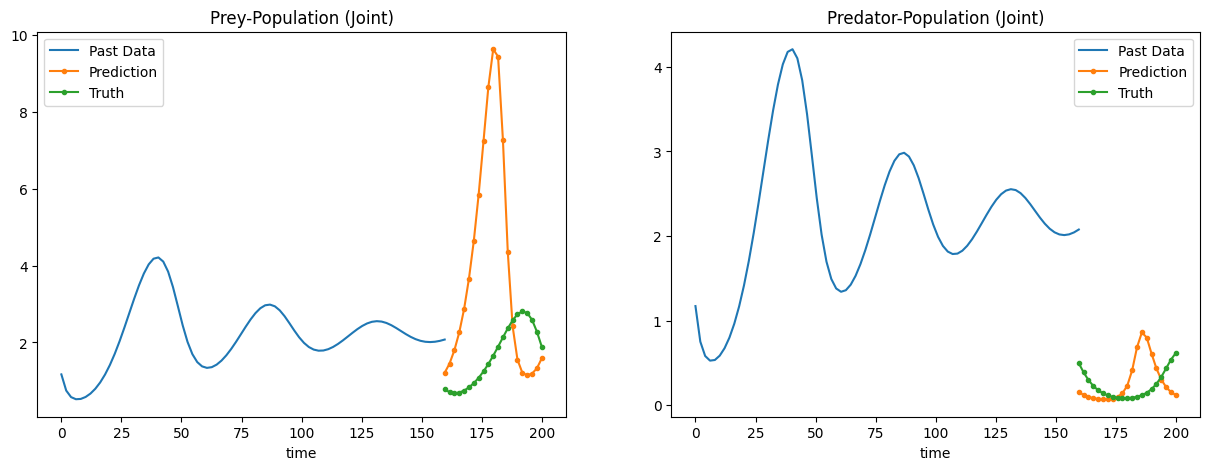

In [110]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

hist_prey = data_prey[-len(test_encoded):]
hist_pred = data_pred[-len(test_encoded):]

print(hist_prey.shape, hist_pred.shape)

axs[0].plot(time_data_past, hist_prey[rn].tolist(), label = 'Past Data')
axs[0].plot(time_data_true[:len(prey_decoded_response)], prey_decoded_response, label = 'Prediction', marker = '.')
axs[0].plot(time_data_true, data_prey_true[rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

axs[1].plot(time_data_past, hist_prey[rn].tolist(), label = 'Past Data')
axs[1].plot(time_data_true[:len(prey_decoded_response)], pred_decoded_response, label = 'Prediction', marker = '.')
axs[1].plot(time_data_true, data_pred_true[rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()

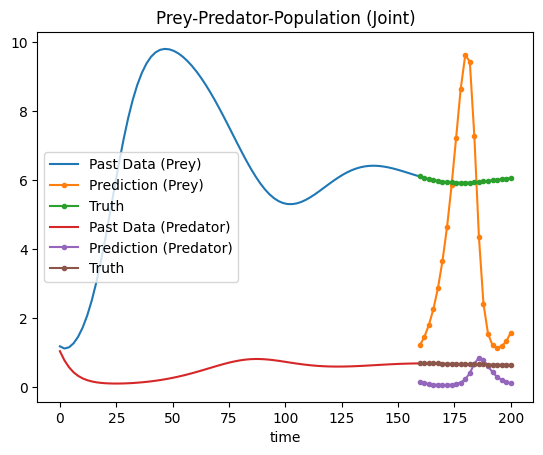

In [73]:

''' 
Jointly show them in the same plot 
'''

print()

plt.plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data (Prey)')
plt.plot(time_data_true, prey_decoded_response, label = 'Prediction (Prey)', marker = '.')
plt.plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data (Predator)')
plt.plot(time_data_true, pred_decoded_response, label = 'Prediction (Predator)', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.xlabel('time')
plt.title('Prey-Predator-Population (Joint)')
plt.legend()
plt.show()

### Evaluation

In [ ]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def compute_forecasting_metrics(true_data, predicted_data):
    
    true_prey, true_pred = true_data
    predicted_prey, predicted_pred = predicted_data[:, 0, :], predicted_data[:, 1, :]
    
    metrics = {'Prey' : {}, 'Predator' : {}}
    data_true = {'Prey': true_prey, 'Predator': true_pred}
    data_predicted = {'Prey': predicted_prey, 'Predator': predicted_pred}
    
    for m in metrics:
        
        # Basic Regression Metrics
        predicted = data_predicted[m]
        true = data_true[m][:, :predicted.shape[-1]]
        
        print(predicted.shape, true.shape)
        
        metrics[m]['MAE'] = mean_absolute_error(true, predicted)
        metrics[m]['MSE'] = mean_squared_error(true, predicted)
        metrics[m]['RMSE'] = np.sqrt(metrics[m]['MSE'])
        metrics[m]['MAPE'] = np.mean(np.abs((true - predicted) / true)) * 100
        
        # Normalized RMSE
        metrics[m]['NRMSE'] = metrics[m]['RMSE'] / (np.max(true) - np.min(true))
        
    return metrics

def visualize_forecast_comparison(true_data, predicted_data, rn):
    """
    Create visualization comparing true and predicted trajectories
    
    Args:
    true_data (np.ndarray): Ground truth time series data
    predicted_data (np.ndarray): Model predicted time series data
    save_path (str): Path to save the visualization
    """
    plt.figure(figsize=(12, 6))
    
    # plt.plot(time_data_past, true_data[check_rn].tolist(), label = 'Past Data')
    plt.plot(time_data_true[:len(predicted_data[0])], predicted_data[0], label = 'Prediction (Prey)', marker = 'x')
    plt.plot(time_data_true[:len(predicted_data[0])], true_data[0].tolist()[:len(predicted_data[0])], label = 'Truth (Prey)', marker = '.')

    # plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
    plt.plot(time_data_true[:len(predicted_data[-1])], predicted_data[-1], label = 'Prediction (Predator)', marker = 'x')
    plt.plot(time_data_true[:len(predicted_data[-1])], true_data[-1].tolist()[:len(predicted_data[-1])], label = 'Truth (Predator)', marker = '.')

    plt.xlabel('time')
    plt.title('Prey-Predator-Population (Forecast) (Pred-Cut)')
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_lora_model(model, test_prompts, true, tokenizer, inf_max_token, is_instruction = False):
    
    pred_batch = []
    
    for i, test_prompt in enumerate(test_prompts):
        if is_instruction:
            test_prompt = create_forecast_prompt_joint(test_prompt, forecast_length=21, is_show = True)
        
        prey_pred_response = generate_forecast(model, test_prompt, tokenizer, max_new_tokens=inf_max_token, temperature=0.1)
        prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)
        prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][i], scale_factors=prey_os['scale'][i])[:forecast_length]
        pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]
        
        min_len = min(len(prey_decoded_response), len(pred_decoded_response))
        ### This can be inhomogenous because the min_len can be different for different generations
        # pred_batch.append([prey_decoded_response[:min_len], pred_decoded_response[:min_len]])
        pred_batch.append([prey_decoded_response, pred_decoded_response])
    
    ## for homogeneity
    min_len = min([min(len(data[0]), len(data[-1])) for data in pred_batch])      
    pred_batch = [[data[0][:min_len], data[-1][:min_len]] for data in pred_batch]
    pred_batch = np.array(pred_batch)
    metrics = compute_forecasting_metrics(true, pred_batch)
    
    rn = random.randint(0, len(pred_batch[0]) - 1)
    visualize_forecast_comparison([true[0][rn], true[-1][rn]], [pred_batch[0][rn], pred_batch[-1][rn]], rn)
    
    return metrics


In [ ]:
rn_idx = np.random.premutation(len(test_encoded))
test_prompts = test_encoded[rn_idx]
val_true_prey, val_true_pred = data_prey_true[int(train_split * len(data_prey_true)):], data_pred_true[int(train_split * len(data_pred_true)):]
val_true_prey, val_true_pred = val_true_prey[rn_idx], val_true_pred[rn_idx]

print(test_prompts.shape, val_true_prey.shape, val_true_pred.shape)

In [ ]:
'''
Load best model and configuration | 30K Steps One | For Now using Normal Model
'''

metrics = evaluate_lora_model(model_lora, test_prompts, [val_true_prey, val_true_pred], tokenizer, max_ctx_length)
pprint(metrics)

In [ ]:
# Print and save metrics
# import json
# print("Model Evaluation Metrics:")
# print(json.dumps(metrics, indent=2))

# with open('../saves/model_metrics.json', 'w') as f:
#     json.dump(metrics, f, indent=2)